In [15]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from torchvision.models.video import r3d_18
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy

In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


## Dataset & Training Loop

In [17]:
class RandomRotation3D(object):
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        """
        Args:
            img (numpy.ndarray): Input 3D image numpy array.

        Returns:
            numpy.ndarray: Randomly rotated image.
        """
        # Randomly select the rotation angle
        angle = np.random.uniform(-self.degrees, self.degrees)

        # Perform rotation
        rotated_img = np.array([np.rot90(slice, k=int(angle / 90)) for slice in img])

        return rotated_img

train_transform = transforms.Compose([
    RandomRotation3D(degrees=5)
])


class AbdominalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label = self.data_frame['target']

        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, -2])

        image = np.load(img_name)
        label = self.label[idx]

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        resized_image = F.interpolate(torch.tensor(image).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze().numpy()

        # Select only the last 64 slices: 
        resized_image = resized_image[-64:, :, :]

        if self.transform:
            resized_image = self.transform(resized_image)
            
        # Normalize the image
        min_image = np.min(resized_image)
        max_image = np.max(resized_image)
        resized_image = (resized_image - min_image) / (max_image - min_image + 1e-4)

    
        # Convert to tensors
        image = torch.tensor(resized_image).float().unsqueeze(0)
        label = torch.tensor(label).long()

        sample = {'x': image, 'y': label}
        return sample



In [18]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, verbose=False):
    acc_dict = {'train': [], 'validate': []}
    loss_dict = {'train': [], 'validate': []}
    best_loss = 1e30
    phases = ['train', 'validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs - 1))
        print('-' * 10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()
                image, label = data['x'], data['y']
                image = image.to(device)
                label = label.to(device)
                outputs = model(image)
                loss = loss_fn(outputs.squeeze(),  label.float())  # Squeeze the output to remove the extra dimension

                if p == 'train':
                    loss.backward()
                    optimizer.step()

                preds = torch.round(torch.sigmoid(outputs))  # Round the sigmoid output to get 0 or 1
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds == label).item()
                running_loss += loss.item() * num_imgs
                running_total += num_imgs

            epoch_acc = float(running_correct / running_total)
            epoch_loss = float(running_loss / running_total)
            if verbose or (i % 10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))

            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(model.state_dict())

        # scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    # Calculate F1 score for the validation set
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for data in dataloader['validate']:
            optimizer.zero_grad()
            image, label = data['x'], data['y']
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            preds = torch.round(torch.sigmoid(outputs))  # Round the sigmoid output to get 0 or 1
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(label.cpu().numpy())
            
    val_f1 = f1_score(val_labels, val_preds)

    print('Best F1: {:4f}'.format(val_f1))

    return model, acc_dict, loss_dict


## ResNet18-2D with LSTM Model

In [19]:
class ResNetLSTM(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(ResNetLSTM, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights='DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Change the last fully connected layer
        self.resnet.fc = nn.Linear(512, 128)
        
        # Define LSTM parameters
        input_size = 128
        hidden_size = 64
        num_layers = 1
        bidirectional = True
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 64)  # Additional dense layer
        self.fc2 = nn.Linear(64, 1)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate*3)
        
        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2 if bidirectional else hidden_size)

    def forward(self, x):
        batch_size, _, num_slices, h, w = x.size()
        
        # Pass through ResNet
        x = x.view(batch_size * num_slices, 1, h, w)
        x = self.resnet(x)
        
        # Reshape for LSTM
        x = x.view(batch_size, num_slices, -1)
            
        # Pass through LSTM
        x, _ = self.lstm(x)

        # Global average pooling across slices
        x, _ = torch.max(x, dim=1)

        # Apply Batch Norm
        x = self.batch_norm(x)

        
        # Apply dropout
        x = self.dropout1(x)
        
        # Pass through additional dense layer
        x = self.fc1(x)
        x = torch.relu(x)
        
        # Apply dropout
        x = self.dropout2(x)
        
        # Pass through final dense layer
        x = self.fc2(x)
        
        return x.squeeze()  

## Hyperparameter Tuning

In [20]:
#TESTING LR AND BATCH SIZE:
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [8, 16]

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

tested_models = []
acc_dicts = []
loss_dicts = []



for l in learning_rates:
    for bs in batch_sizes:
        print('Learning Rate:', l)
        print('Batch Size:', bs)
        
        model = ResNetLSTM().to(device)

        pos_weight = torch.tensor(10.0).to(device)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight, reduction='mean')

        optimizer = optim.Adam(model.parameters(), lr=l, weight_decay=1e-4)

        dataset = {'train': AbdominalDataset(os.path.join(data_directory, 'train_sample_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/', train_transform), 
                   'validate': AbdominalDataset(os.path.join(data_directory, 'val_sample_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/'),
                   'test': AbdominalDataset(os.path.join(data_directory, 'test_sample_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/')}
        
        dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                                shuffle=True) for x in ['train', 'validate']}

        model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs=10, verbose=True)
        tested_models.append(model)
        acc_dicts.append(acc_dict)
        loss_dicts.append(loss_dict)


Learning Rate: 0.001
Batch Size: 8
Epoch: 0/9
----------
Phase:train, epoch loss: 1.1886 Acc: 0.5372
Phase:validate, epoch loss: 1.7567 Acc: 0.8723
Epoch: 1/9
----------
Phase:train, epoch loss: 1.1463 Acc: 0.5798
Phase:validate, epoch loss: 3.2126 Acc: 0.8723
Epoch: 2/9
----------
Phase:train, epoch loss: 1.2437 Acc: 0.5532
Phase:validate, epoch loss: 1.5014 Acc: 0.7713
Epoch: 3/9
----------
Phase:train, epoch loss: 1.2043 Acc: 0.5798
Phase:validate, epoch loss: 1.6543 Acc: 0.1383
Epoch: 4/9
----------
Phase:train, epoch loss: 1.1052 Acc: 0.5851
Phase:validate, epoch loss: 2.1199 Acc: 0.1383
Epoch: 5/9
----------
Phase:train, epoch loss: 1.0152 Acc: 0.6330
Phase:validate, epoch loss: 1.5258 Acc: 0.1702
Epoch: 6/9
----------
Phase:train, epoch loss: 1.2418 Acc: 0.5213
Phase:validate, epoch loss: 1.6750 Acc: 0.7819
Epoch: 7/9
----------
Phase:train, epoch loss: 1.1388 Acc: 0.5585
Phase:validate, epoch loss: 3.0113 Acc: 0.8723
Epoch: 8/9
----------
Phase:train, epoch loss: 1.0175 Acc: 0.

In [24]:
# Save models
with open('models_hyperparameter_resnet_LSTM.pkl', 'wb') as f:
    pickle.dump(tested_models, f)

# Save acc_dicts
with open('acc_dicts_hyperparameter_resnet_LSTM.pkl', 'wb') as f:
    pickle.dump(acc_dicts, f)

# Save loss_dicts
with open('loss_dicts_hyperparameter_resnet_LSTM.pkl', 'wb') as f:
    pickle.dump(loss_dicts, f)

In [25]:
# Load models
with open('models_hyperparameter_resnet_LSTM.pkl', 'rb') as f:
    tested_models = pickle.load(f)

# Load acc_dicts
with open('acc_dicts_hyperparameter_resnet_LSTM.pkl', 'rb') as f:
    acc_dicts = pickle.load(f)

# Load loss_dicts
with open('loss_dicts_hyperparameter_resnet_LSTM.pkl', 'rb') as f:
    loss_dicts = pickle.load(f)

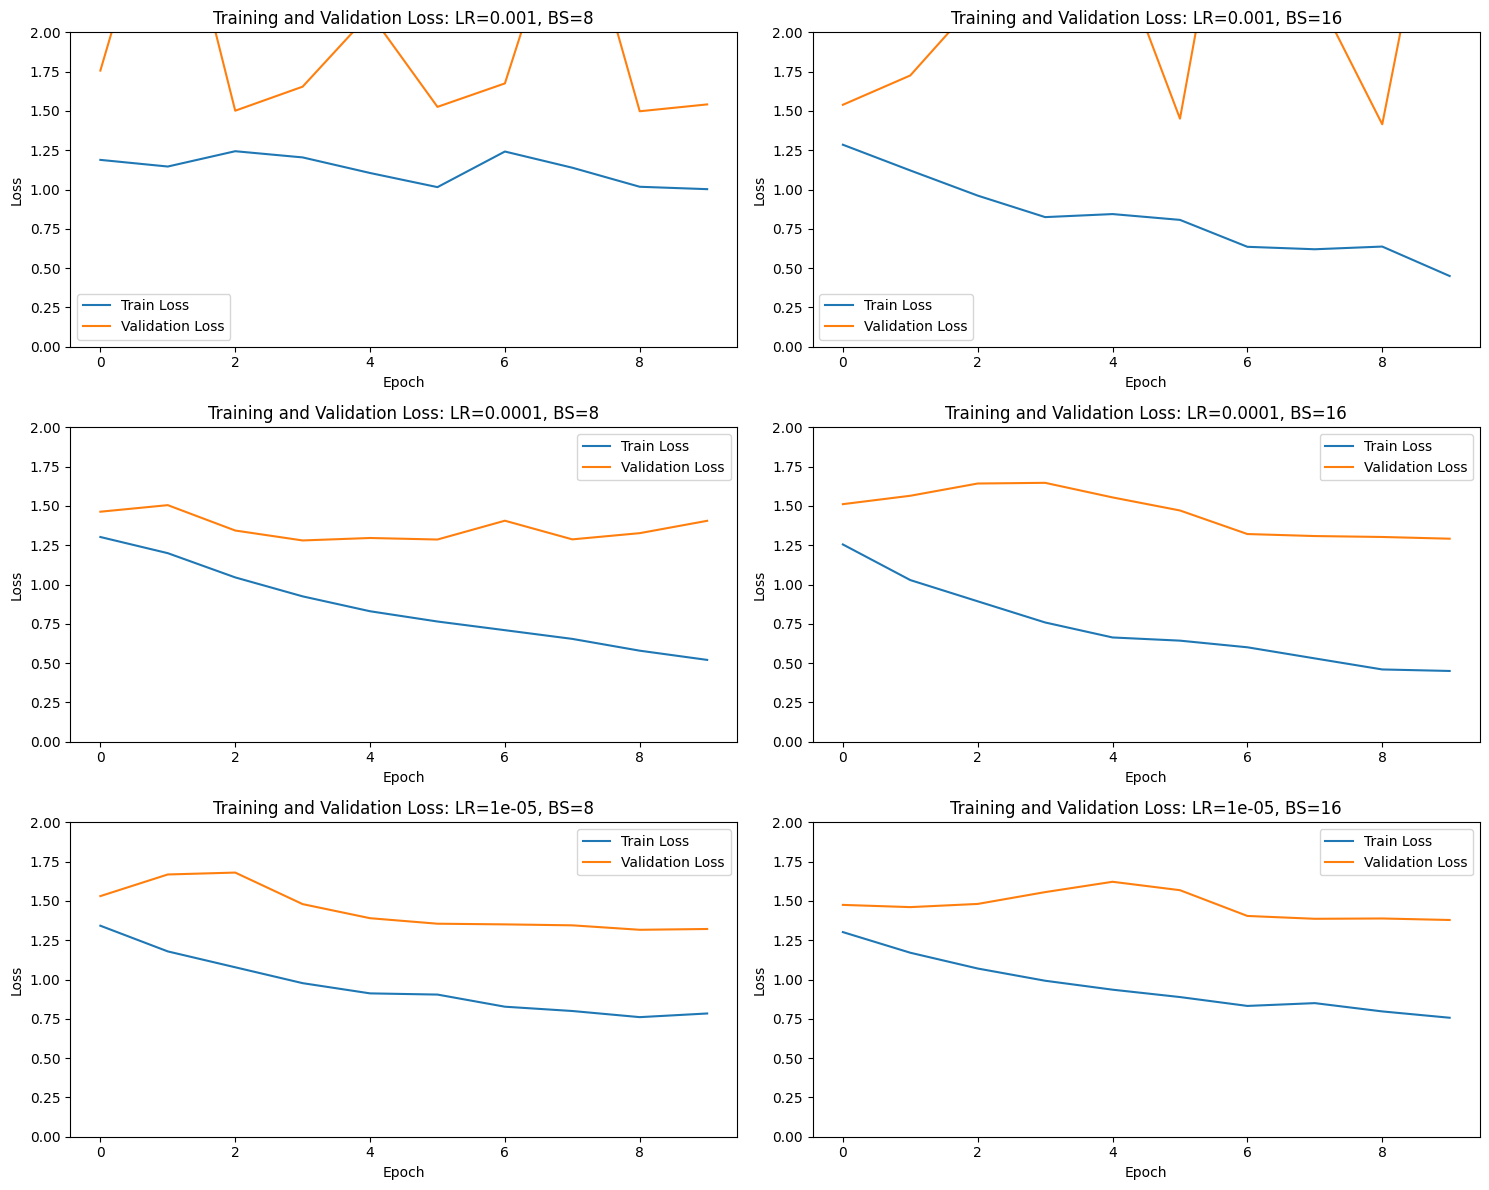

In [26]:
#LOSS:
fig, axs = plt.subplots(len(learning_rates), len(batch_sizes), figsize=(15, 12))
idx = 0
for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        loss_dict = loss_dicts[idx]
        model = tested_models[idx]

        axs[i, j].plot(range(0,len(loss_dict['train'])),loss_dict['train'], label='Train Loss')
        axs[i, j].plot(range(0,len(loss_dict['validate'])),loss_dict['validate'], label='Validation Loss')
        axs[i, j].set_title(f'Training and Validation Loss: LR={lr}, BS={bs}')
        axs[i, j].set_xlabel('Epoch')
        axs[i, j].set_ylabel('Loss')
        axs[i,j].set_ylim(0,2)
        axs[i, j].legend()
        idx += 1


plt.tight_layout()
plt.show()



In [27]:
def evaluate_hyperparameter_tuning(model, dataloader, device):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_probs = np.array([])  # To store predicted probabilities
    all_preds = np.array([])  # To store predicted class labels
    
    with torch.no_grad():
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            outputs = model(image)
            
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs) 
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_probs = np.concatenate((all_probs, probs.cpu().numpy()), axis=0)  # Use probabilities for the positive class
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            
            total_samples += labels.size(0)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate AUC score
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc_score = auc(fpr, tpr)

     # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate FNR and FPR
    fnr = fn / (fn + tp)
    fpr = fp / (tn + fp)

    # Calculate AUPRC score
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    auprc_score = average_precision_score(all_labels, all_probs)

    return f1, auc_score, auprc_score, fnr, fpr

hyperparam_eval_dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=False, num_workers=0) for x in ['validate']}
idx = 0

for i, l in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        model = tested_models[idx]
        f1, auc_score, auprc_score, fnr, fpr = evaluate_hyperparameter_tuning(model, hyperparam_eval_dataloader['validate'], device)
        idx += 1
        print("Learning Rate:", l, "Batch Size:", bs, "Val F1:", f1, "Val AUC:", auc_score, "Val AUPRC:", auprc_score, "Val FNR", fnr, "Val FPR", fpr)

/ext3/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Learning Rate: 0.001 Batch Size: 8 Val F1: 0.3939393939393939 Val AUC: 0.74364837398374 Val AUPRC: 0.33666429320942737 Val FNR 0.4583333333333333 Val FPR 0.17682926829268292


/ext3/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Learning Rate: 0.001 Batch Size: 16 Val F1: 0.3888888888888889 Val AUC: 0.7289126016260163 Val AUPRC: 0.3204749131843864 Val FNR 0.4166666666666667 Val FPR 0.2073170731707317


/ext3/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Learning Rate: 0.0001 Batch Size: 8 Val F1: 0.3384615384615385 Val AUC: 0.7428861788617886 Val AUPRC: 0.27042476312149416 Val FNR 0.08333333333333333 Val FPR 0.5121951219512195


/ext3/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Learning Rate: 0.0001 Batch Size: 16 Val F1: 0.35555555555555557 Val AUC: 0.7550813008130082 Val AUPRC: 0.24723137789831937 Val FNR 0.3333333333333333 Val FPR 0.3048780487804878


/ext3/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Learning Rate: 1e-05 Batch Size: 8 Val F1: 0.3877551020408163 Val AUC: 0.8051321138211383 Val AUPRC: 0.3566019374888318 Val FNR 0.20833333333333334 Val FPR 0.3353658536585366


/ext3/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Learning Rate: 1e-05 Batch Size: 16 Val F1: 0.2875 Val AUC: 0.6953760162601625 Val AUPRC: 0.23017727969872973 Val FNR 0.041666666666666664 Val FPR 0.6890243902439024


## Train Full Model

In [28]:
bs = 8
lr = 0.00001

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

model = ResNetLSTM().to(device)

pos_weight = torch.tensor(10.0).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight, reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

dataset = {'train': AbdominalDataset(os.path.join(data_directory, 'train_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/', train_transform), 
           'validate': AbdominalDataset(os.path.join(data_directory, 'val_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/'),
           'test': AbdominalDataset(os.path.join(data_directory, 'test_binary.csv'),'/vast/amr10211/deep_learning_final_project/masked_images/')}

dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=True) for x in ['train', 'validate']}

model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs=10, verbose=True)


Epoch: 0/9
----------
Phase:train, epoch loss: 1.3249 Acc: 0.7710
Phase:validate, epoch loss: 1.3814 Acc: 0.7660
Epoch: 1/9
----------
Phase:train, epoch loss: 1.2397 Acc: 0.7293
Phase:validate, epoch loss: 1.3455 Acc: 0.7255
Epoch: 2/9
----------
Phase:train, epoch loss: 1.1951 Acc: 0.7134
Phase:validate, epoch loss: 1.3278 Acc: 0.6915
Epoch: 3/9
----------
Phase:train, epoch loss: 1.1555 Acc: 0.7067
Phase:validate, epoch loss: 1.3031 Acc: 0.6532
Epoch: 4/9
----------
Phase:train, epoch loss: 1.1046 Acc: 0.7107
Phase:validate, epoch loss: 1.3056 Acc: 0.6638
Epoch: 5/9
----------
Phase:train, epoch loss: 1.0515 Acc: 0.7113
Phase:validate, epoch loss: 1.2925 Acc: 0.6702
Epoch: 6/9
----------
Phase:train, epoch loss: 0.9983 Acc: 0.7219
Phase:validate, epoch loss: 1.2811 Acc: 0.6723
Epoch: 7/9
----------
Phase:train, epoch loss: 0.9551 Acc: 0.7325
Phase:validate, epoch loss: 1.2684 Acc: 0.6745
Epoch: 8/9
----------
Phase:train, epoch loss: 0.8734 Acc: 0.7489
Phase:validate, epoch loss: 1.

In [29]:
torch.save(model.state_dict(), 'classification_model_resnet18_LSTM_cropped_binary_0_9_final.pth')

In [30]:
with open('acc_dict_resnet18_LSTM_cropped_binary_0_9_final.pickle', 'wb') as handle:
    pickle.dump(acc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open('loss_dict_resnet18_LSTM_cropped_binary_0_9_final.pickle', 'wb') as handle:
    pickle.dump(loss_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Evaluate Model

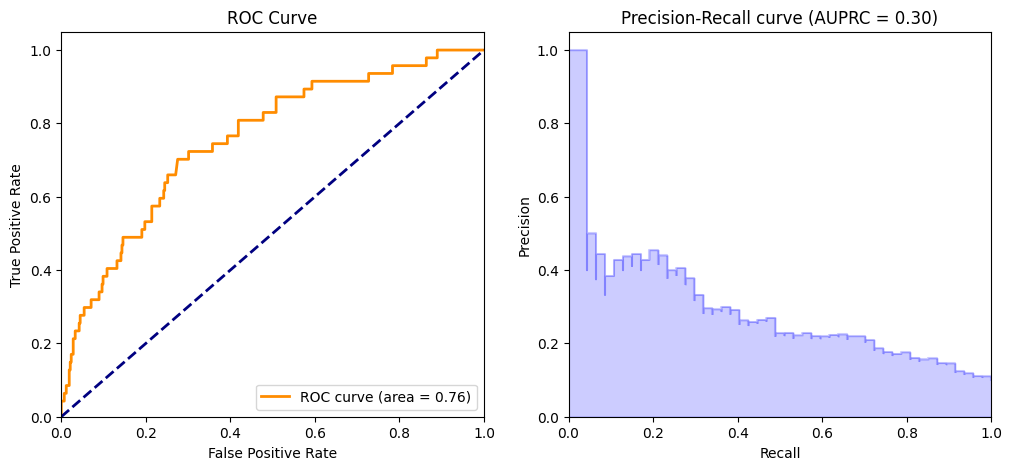

Test F1: 0.3316582914572864
Test AUC: 0.7551939924906133
Test AUPRC: 0.3003340229748538
Test FNR: 0.2978723404255319
Test FPR: 0.28


In [32]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_samples = 0
    
    all_labels = np.array([])
    all_probs = np.array([])  # To store predicted probabilities
    all_preds = np.array([])  # To store predicted class labels
    
    with torch.no_grad():
        for data in dataloader:
            image = data['x'].to(device)
            labels = data['y'].to(device)
            outputs = model(image)
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs) 
            
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()), axis=0)
            all_probs = np.concatenate((all_probs, probs.cpu().numpy()), axis=0)
            all_preds = np.concatenate((all_preds, preds.cpu().numpy()), axis=0)
            
            total_samples += labels.size(0)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate FNR and FPR
    fnr = fn / (fn + tp)
    fpr = fp / (tn + fp)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate AUC score
    fprs, tprs, _ = roc_curve(all_labels, all_probs)
    auc_score = auc(fprs, tprs)
    
    # Calculate AUPRC score
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    auprc_score = average_precision_score(all_labels, all_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(fprs, tprs, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (AUPRC = %0.2f)' % auprc_score)
    
    plt.show()
        
    return f1, auc_score, auprc_score, fnr, fpr

eval_dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=False, num_workers=0) for x in ['test']}

test_f1, test_auc, test_auprc, test_fnr, test_fpr = evaluate_model(model, eval_dataloader['test'], device)
print("Test F1:", test_f1)
print("Test AUC:", test_auc)
print("Test AUPRC:", test_auprc)
print("Test FNR:", test_fnr)
print("Test FPR:", test_fpr)
